In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 1
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
cfg = local_import("./laptop.py")

In [4]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Shape of dictionary (3048821, 4)
Warning! Dropping some words from word list, please verify!
Dropping 1211
Shape of merged df (1000000, 33)
Selecting only questions with at least 3 meaningful words.
This removes 8582 questions.
Removing bad values with missing feature information.
This affects 19 questions.
Calculating normalized columns. They are available under usual column name + _norm.


In [5]:
data = cfg.data

In [6]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [7]:
qs = data["meta"];

In [8]:
qs.head()
print qs.shape

(991399, 52)


/usr/lib/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning:

invalid value encountered in greater_equal

/usr/lib/python2.7/site-packages/numpy/lib/function_base.py:749: RuntimeWarning:

invalid value encountered in less_equal



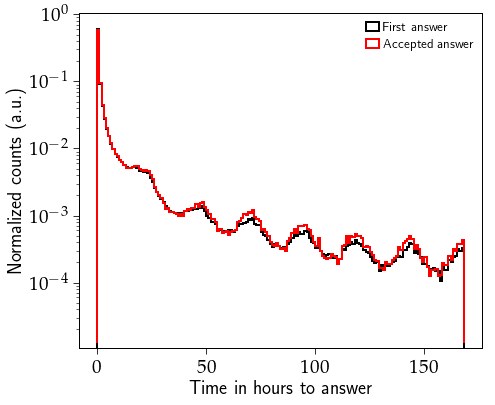

In [9]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Normalized counts (a.u.)")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", normed=True, log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", normed=True, log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_first_accepted_normed.pdf")

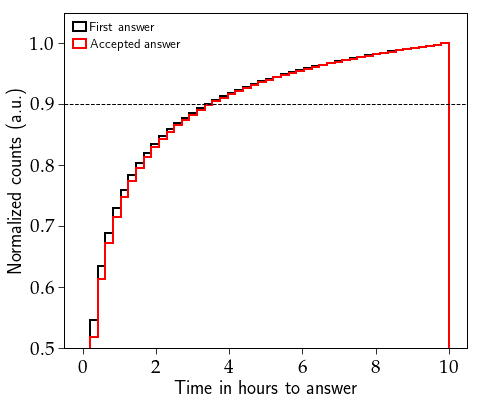

In [10]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Normalized counts (a.u.)")
plt.hist(qs.dt_answer_hour, range=[0, 10], bins=48, cumulative=True,
         histtype="step", lw=2, color="k", label="First answer", normed=True, log=False);
plt.hist(qs.dt_accanswer_hour, range=[0, 10], bins=48, cumulative=True,
        histtype="step", lw=2, color="r", label="Accepted answer", normed=True, log=False);
# plt.semilogy(nonposy="clip")
plt.axhline(0.9, lw=1, ls="--", color="black")
plt.ylim(0.5, 1.05)
plt.legend(loc="upper left")
plt.savefig("./plots/dthist_first_accepted_normed_cum.pdf")

In [27]:
# testing plotly library
data = [go.Histogram(x=qs.dt_accanswer_hour, xbins=dict(start=0, end=10, size=0.2),
                     cumulative=dict(enabled=True), histnorm="percent")]

plotly.offline.iplot(data, filename='cumulative histogram')

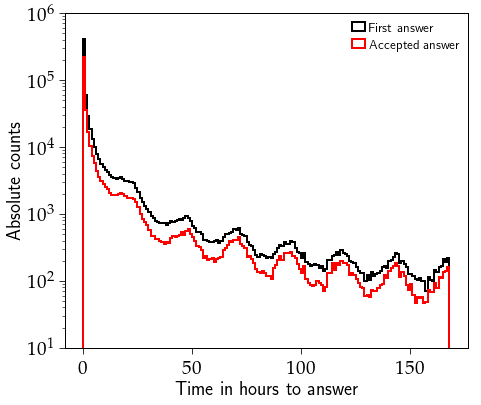

In [11]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", log=True);
# plt.semilogy(nonposy="clip")
plt.ylim(10, 10 ** 6)
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_first_accepted.pdf")

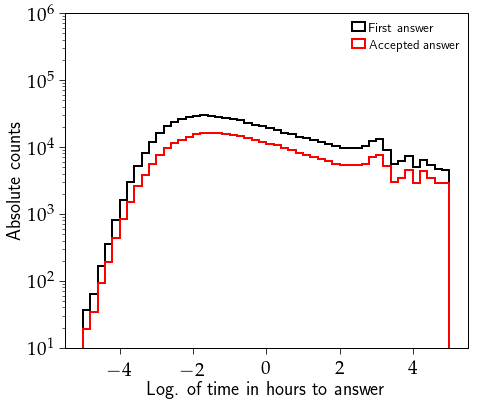

In [12]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Log. of time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour.apply(np.log), bins=50, 
         histtype="step", lw=2, color="k", range=[-5, 5], label="First answer", log=True);
plt.hist(qs.dt_accanswer_hour.apply(np.log), bins=50,
        histtype="step", lw=2, color="r", range=[-5, 5], label="Accepted answer", log=True);
# plt.semilogy(nonposy="clip")
plt.ylim(10, 10 ** 6)
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_log_first_accepted.pdf")

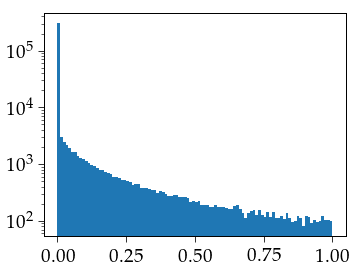

In [12]:
plt.hist(qs.dt_accanswer_hour - qs.dt_answer_hour, range=[0, 1], bins=100, log=True);
# plt.semilogy(nonposy="clip")

In [14]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

706703
386998


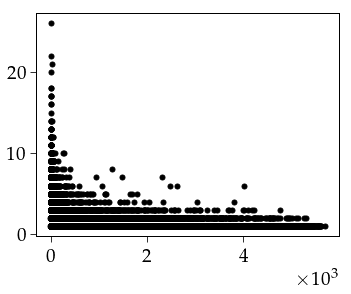

In [15]:
plt.plot(qs.dt_answer_hour, qs.AnswerCount, "k.")

In [16]:
qs.columns
cols_desc

{'AnswerCount': 'Number of replies',
 'BodyNCodes': 'Number of code tags',
 'BodyNQMarks': 'Number of question marks',
 'BodySize': 'Length of post text',
 'Score': 'Question score',
 'nwords': 'Number of meaningful words',
 'ordermean': 'Word prevalence (average)',
 'orderstd': 'Word prevalence (std)',
 'ordersum': 'Word prevalence (sum)',
 'prob_bern': 'Joined bernoulli probability of words',
 'ratio': 'Ratio of number of verbs to nouns',
 'titlelen': 'Length of title'}

In [16]:
qs.columns
m = np.isfinite(qs.dt_accanswer_hour)

no = qs.AnswerCount == 0

ndays = 7
# dthours = qs.dt_answer.dt.total_seconds() * 1. / 3600
cols = ["AnswerCount", "BodyNCodes", "BodyNQMarks", "BodySize", 
        "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio", "Score", "prob_bern"]

xqbins = mquantiles(qs.dt_accanswer_hour[m], np.linspace(0, 1, 15))

xqbins = xqbins[xqbins < ndays * 24]
if len(xqbins) % 2 == 1:
    xqbins = xqbins[:-1]
    
for i, col in enumerate(cols):
    print "Plotting for column %s..." % col
    quants = mquantiles(qs[m][col], prob=[0.01, 0.1, 0.9, 0.95])
#     print quants
    plt.figure(figsize=(8, 6))
    plt.xlabel(r"Time to accepted answer / hours")
    plt.ylabel(r"%s" % cols_desc[col])
#     plt.plot(dthours, qs[col], "k.")
    QuickSlicePlot(qs.dt_accanswer_hour[m], qs[m][col], qs.dt_accanswer_hour[m], zbins=1, yrange=quants[1:-1], 
#                    xRange=[0, ndays * 24], xbins=2 * ndays, draw="amvs",
                   xbins=xqbins, draw="amvc", outliers=True, ms=6, color="black", textpos=quants[2],
                   axes=plt.gca(), label="Answered questions")
    
    ViolinPlot(np.asfarray([(ndays + 1) * 24]), np.asfarray([qs[no][col]]), xhw=np.asfarray([80]),
               bins=None, draw="amvc", outliers=True, ms=6, color="blue", textpos=quants[2],
               axes=plt.gca(), label="Unanswered questions")
    
    plt.axhline(np.median(qs[m][col]), ls="--", lw=1, color="black")
    plt.xlim(0.006, (ndays + 3) * 24)
    plt.ylim(quants[0], quants[-1])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    plt.semilogx()
    plt.legend(loc="upper left")
#     plt.show()
    plt.savefig("./plots/%s_vs_answertime.pdf" % col)
    plt.close()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

Plotting for column AnswerCount...


stack_util.py:258: RuntimeWarning:

divide by zero encountered in log10



Warning! Error in estimating kernel density for data in bin 0! Skipping bin...
Plotting for column BodyNCodes...
Plotting for column BodyNQMarks...
Plotting for column BodySize...
Plotting for column titlelen...
Plotting for column nwords...
Plotting for column ordersum...
Plotting for column ordermean...
Plotting for column orderstd...


/usr/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning:

Invalid value encountered in median



Plotting for column ratio...
Plotting for column Score...
Plotting for column prob_bern...


In [17]:
qs["dayhour"] = qs.CreationDate.dt.hour
qs["weekday"] = qs.CreationDate.dt.dayofweek
qs["day"] = qs.CreationDate.dt.dayofyear
# training and testing samples
qs = shuffle(qs)
print "Length of the whole shuffled question df:", len(qs)
# limiting to questions with accepted answer for training
qsgood = qs[np.isfinite(qs.dt_accanswer_hour)]

# for training, consider only first weeks for answer time (due to reweighting)
qsgood = qsgood[qsgood.dt_accanswer_hour <= 14 * 24]
qsgood = qsgood[qsgood.dt_accanswer_hour > 0]
print "Number of good (selected) questions with accepted answer:", len(qsgood)
train = 150000
qstrain = qsgood.iloc[:train]
qstest = qsgood.iloc[train:]
print "Length of the training set:", len(qstrain)
print "Length of the testing set:", len(qstest)

label = "dt_accanswer_hour"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print "Number of questions without answer:", len(qsnone)

Length of the whole shuffled question df: 991399
Number of good (selected) questions with accepted answer: 374937
Length of the training set: 150000
Length of the testing set: 224937
Number of questions without answer: 284672


In [18]:
qstrain.head()

,AcceptedAnswerId,AnswerCount,BodyNCodes,BodyNQMarks,BodySize,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,...,BodyNCodes_norm,BodyNQMarks_norm,BodySize_norm,titlelen_norm,nwords_norm,ordersum_norm,ordermean_norm,orderstd_norm,ratio_norm,day
640313,43153978,1,3,1,711,-1.0,0,-1.0,2017-04-01 06:21:40.233600,-1,...,0.214286,0.1,0.050865,0.55,0.159420,0.230891,0.307927,0.580364,0.384615,91
875778,43787071,1,1,0,2124,-1.0,6,-1.0,2017-05-04 15:01:07.132800,-1,...,0.071429,0.0,0.181541,0.36,0.275362,0.220299,0.246193,0.377021,0.353846,124
764855,43489680,1,2,0,1448,-1.0,0,-1.0,2017-04-19 07:34:29.740800,0,...,0.142857,0.0,0.119023,0.05,0.123188,0.283500,0.550735,0.655979,0.500000,109
218151,42010995,2,2,1,931,-1.0,0,-1.0,2017-02-02 19:31:43.507200,-1,...,0.142857,0.1,0.071211,0.56,0.159420,0.013696,0.001309,-0.001311,0.206478,33
4049,41439135,1,1,8,2115,-1.0,0,-1.0,2017-01-02 09:20:46.060800,1,...,0.071429,0.8,0.180708,0.48,0.289855,0.406592,0.799131,0.768112,0.072650,2


In [63]:
# we probably want to reweight events according to the steeply falling time distribution...
#max(qstrain.dt_accanswer_hour)
# counts, edges = np.histogram(qstrain.dt_accanswer_hour, mquantiles(qstrain.dt_accanswer_hour, prob=np.linspace(0., 1., 100)))
from pyik.numpyext import centers

counts, edges = np.histogram(np.log(qstrain.dt_accanswer_hour), bins=300)
cens = centers(edges)[0]
counts = counts * 1. / np.sum(counts)
counts;
print edges[:10];
weights = 1. / counts[np.minimum(np.digitize(np.log(qstrain.dt_accanswer_hour.values), edges) - 1, len(counts) - 1)]
print qstrain.dt_accanswer_hour.iloc[:10]
qstrain["weights"] = weights
print qstrain.weights.iloc[:10]

[-5.49579317 -5.45808351 -5.42037384 -5.38266417 -5.34495451 -5.30724484
 -5.26953518 -5.23182551 -5.19411584 -5.15640618]
620375     0.052104
95913      1.049640
897957     1.876464
897738    44.065008
280282     0.335424
747033     4.774488
622690     0.081120
505960     0.041064
669024     0.952992
75081     88.712736
Name: dt_accanswer_hour, dtype: float64
620375    298.507463
95913     181.488203
897957    215.053763
897738    458.715596
280282    125.391850
747033    295.420975
622690    180.180180
505960    408.997955
669024    177.619893
75081     682.593857
Name: weights, dtype: float64


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
qstrain.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordermean', u'orderstd', u'ordersum', u'prob_bern', u'prob_poiss',
       u'ratio', u'ParentId_first', u'CreationDate_first', u'Id_acc',
       u'CreationDate_acc', u'dayhour', u'weekday', u'dt_answer',
       u'dt_accanswer', u'dt_answer_hour', u'dt_accanswer_hour',
       u'BodyNCodes_norm', u'BodyNQMarks_norm', u'BodySize_norm',
       u'titlelen_norm', u'nwords_norm', u'ordersum_norm', u'ordermean_norm',
       u'orderstd_norm', u'ratio_norm', u'day'],
      dtype='object')

In [17]:
import dill
# dill.dump(estimator, open('estimator.dill', 'w'))
# estimator = dill.load(open('estimator.dill', 'r'))

## Fitting random forest to the space of simple features derived from the text

In [19]:
# cols = [col for col in qstrain.columns if "_norm" in col]
# print cols

cols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]

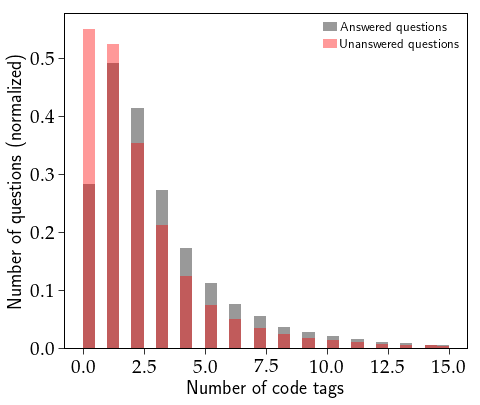

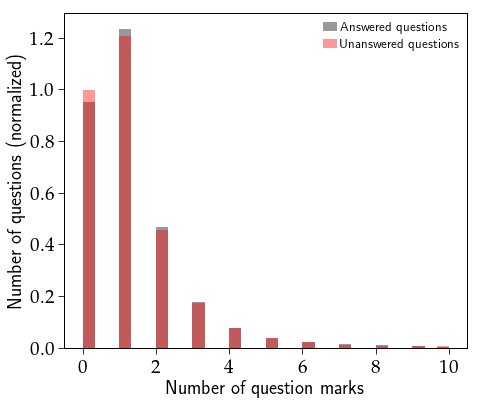

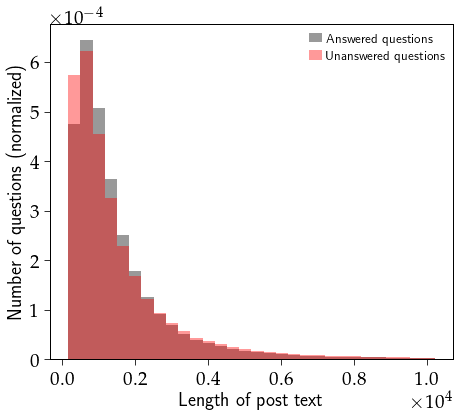

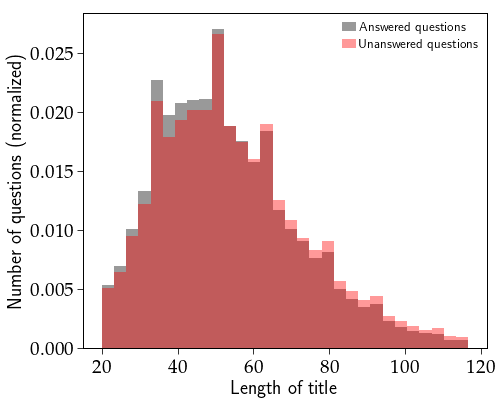

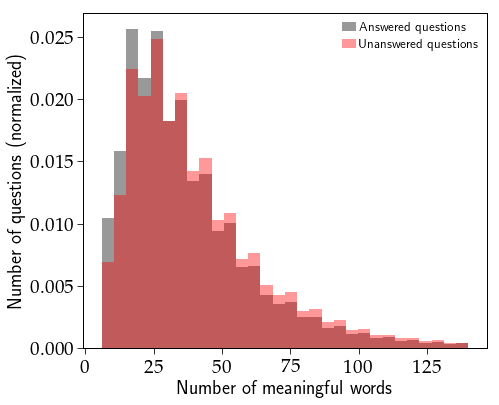

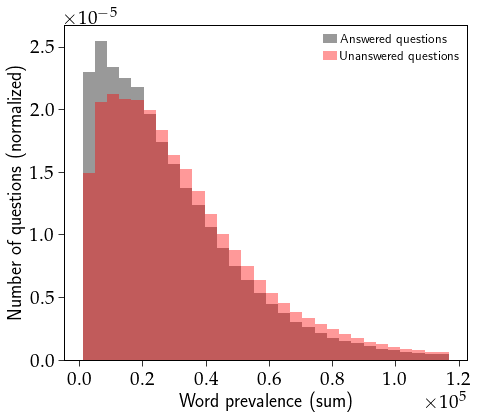

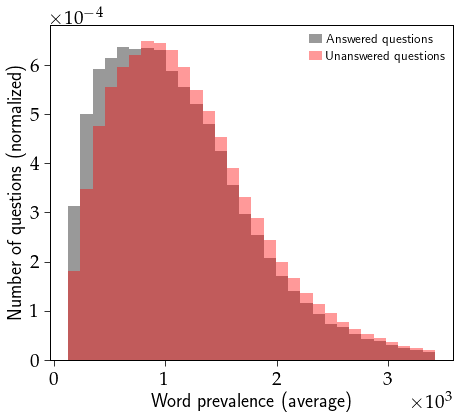

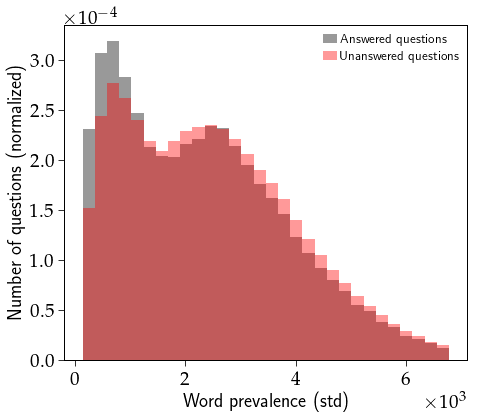

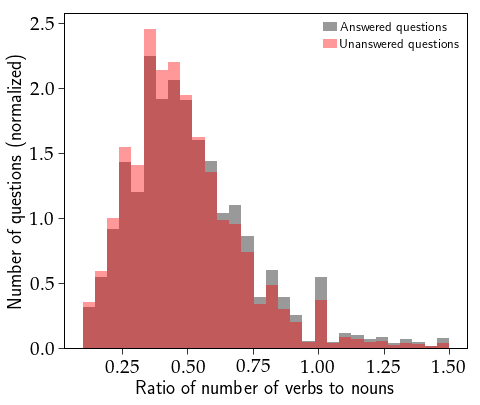

In [16]:
for col in cols:
    cvals = qstrain[col]
    quants = mquantiles(cvals, prob=np.linspace(0.01, 0.99, 30))
    plt.figure(figsize=(8, 6))
    plt.ylabel(r"Number of questions (normalized)")
    plt.xlabel(cols_desc[col])
    plt.hist(qstrain[col], range=[min(quants), max(quants)], bins=30, 
             color="k", histtype="stepfilled", alpha=0.4, lw=2, 
             label="Answered questions", density=True)
    plt.hist(qsnone[col], range=[min(quants), max(quants)], bins=30, 
             color="r", histtype="stepfilled", alpha=0.4, lw=2, 
             label="Unanswered questions", density=True)
#     plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend(loc="best")
    plt.savefig("./plots/histcomp_%s.pdf" % col.replace("_norm", ""))

In [20]:
pipe_time_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(["weekday", "dayhour"])),
         ("onehot", OneHotEncoder(sparse=True)),
#          ("poly", PolynomialFeatures(degree=2)),
         ("ridge", Ridge(alpha=a, normalize=False))
#          ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=False), RandomForestRegressor(n_estimators=20)))
#          ("multi", MultiModelRegressor(SGDRegressor(), RandomForestRegressor(n_estimators=20)))
#          ("ranforest", RandomForestRegressor(n_estimators=15))
    ])

pipe_time = pipe_time_fct(2)

In [21]:
pipe_time.fit(qstrain, np.log(qstrain[label]))
pred = pipe_time.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_time.score(qstest, np.log(qstest[label]))

[[-0.06739073 -1.73187677]
 [ 0.02009209 -2.23074827]
 [ 0.26884091 -2.40024202]
 ..., 
 [-0.03970264 -2.37851626]
 [ 0.08505809 -2.50416287]
 [-0.0151854   0.79987197]]
0.00257002934794


In [40]:
relcols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]
cols = [col + "_norm" for col in relcols]
print cols

from sklearn.linear_model import Lasso

pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(cols)),
         ("poly", PolynomialFeatures(degree=2)),
         ("ridge", Ridge(alpha=a, normalize=False))
#          ("sgd", SGDRegressor(alpha=a))
#          ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=False), RandomForestRegressor(n_estimators=15)))
#          ("multi", MultiModelRegressor(SGDRegressor(), RandomForestRegressor(n_estimators=20)))
#          ("ranforest", RandomForestRegressor(n_estimators=15))
    ])

pipe_feat = pipe_feat_fct(2)

['BodyNCodes_norm', 'BodyNQMarks_norm', 'BodySize_norm', 'titlelen_norm', 'nwords_norm', 'ordersum_norm', 'ordermean_norm', 'orderstd_norm', 'ratio_norm']


In [23]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

In [ ]:
for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

In [41]:
# weighted ridge regression
# pipe_feat.fit(qstrain, np.log(qstrain[label]), **{"ridge__sample_weight": qstrain.weights})
# unweighted
pipe_feat.fit(qstrain, np.log(qstrain[label]))
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_feat.score(qstest, np.log(qstest[label]))
# print compute_error(pipe_feat, qstest, np.log(qstest[label]))
# print pipe_feat.score(qstest, np.log(qstest[label]), sample_weight=qstest.weights)

[[-0.61216095 -1.73187677]
 [-0.6315946  -2.23074827]
 [-0.46829314 -2.40024202]
 ..., 
 [-0.12197718 -2.37851626]
 [-0.72034102 -2.50416287]
 [-0.13387914  0.79987197]]
0.0701796491558


In [44]:
pipe_tags = Pipeline([
                     ("cst", ColumnSelectTransformer(["Tags"])),
                     ("dec", DictEncoder("Tags")),
                     ("dvec", DictVectorizer(sparse=True)),
                     ("tfid", TfidfTransformer()),
                     # ("poly", PolynomialFeatures(degree=2)),  # not working???
#                      ("ridge", Ridge(alpha=2.0))
                     ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=False), RandomForestRegressor(n_estimators=15)))
                     # ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
                     # ("svr", SVR())
                     ])

In [45]:
pipe_tags.fit(qstrain, np.log(qstrain[label]))
pred = pipe_tags.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_tags.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
[[ 2.50372863  0.91705204]
 [ 0.68859679  2.96888591]
 [ 1.2938708   1.26329248]
 ..., 
 [-1.59633655 -1.46409159]
 [ 0.39287452 -0.06258204]
 [-1.01475689 -1.76286885]]
0.124504973648


In [18]:
pipe_words = Pipeline([
                      ("cst", ColumnSelectTransformer(["hot_indices"])),
                      ("dec", DictEncoder("hot_indices")),
                      ("dvec", DictVectorizer(sparse=True)),
                      ("tfid", TfidfTransformer()),
#                       ("ridge", Ridge(alpha=2.0))
#                       ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=15)))
#                       ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=True), MLPRegressor(hidden_layer_sizes=(50, 50))))
                      ("mlp", MLPRegressor(hidden_layer_sizes=(100, 100)))
                      ])

In [19]:
pipe_words.fit(qstrain, np.log(qstrain[label]))
pred = pipe_words.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_words.score(qstest, np.log(qstest[label]))

[[ 0.11661578  1.73275229]
 [-0.68789848  1.62309463]
 [-0.41625747  0.56544562]
 ..., 
 [-0.95755484 -2.74837232]
 [-0.66469107 -2.45769623]
 [-0.03610053 -1.2427968 ]]
0.0427342687598


In [90]:
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([
                     ("tags", EstimatorTransformer(pipe_tags)),
                     ("words", EstimatorTransformer(pipe_words)),
                     ("feat", EstimatorTransformer(pipe_feat))
                     ])

pipe_combined = Pipeline([
                    ("union", union),
                    ("ridge", Ridge(alpha=3.0))
                    # ("comb", CustomCombiner())
                    ])

In [92]:
pipe_combined.fit(qstrain, np.log(qstrain[label]))
pred = pipe_combined.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_combined.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
Performing base regression...
Performing residual regression...
[[-1.38131283 -1.24080278]
 [ 2.58146676  2.53918837]
 [-1.48334503 -2.46557472]
 ..., 
 [-0.68950884 -2.54889492]
 [ 0.51332501 -1.11581542]
 [ 1.50734924  3.57332448]]
0.461645944995


In [93]:
import dill

In [94]:
dill.dump(pipe_combined, open("pipe_feat.dill", "w"))

In [ ]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))

## Investigating difference (residuals) in test sample vs. various dimensions

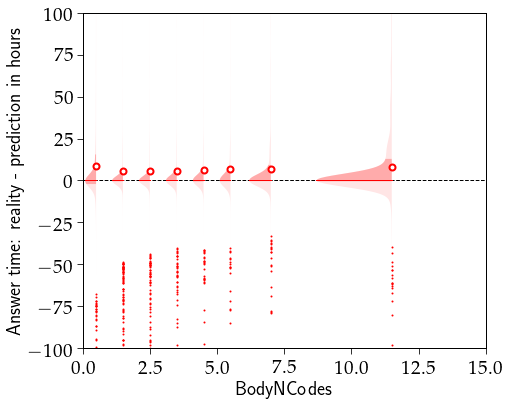

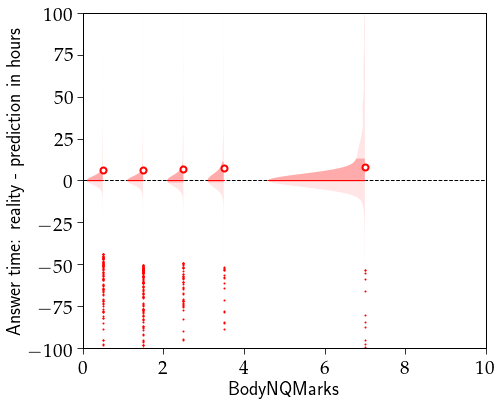

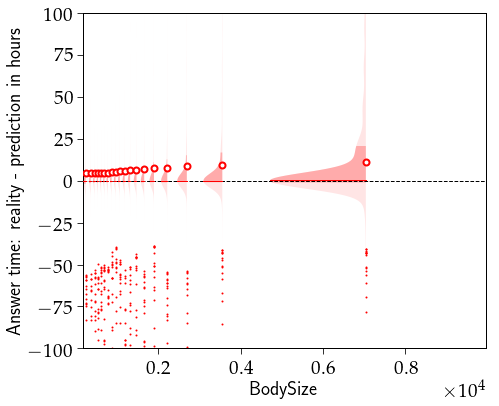

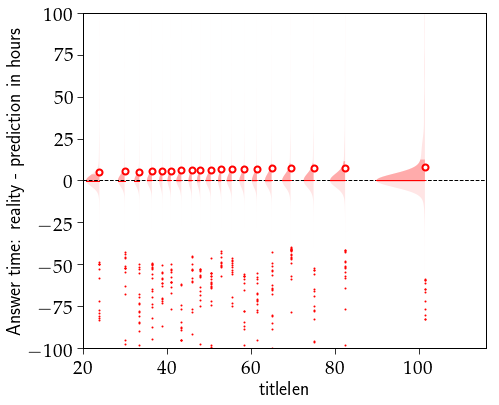

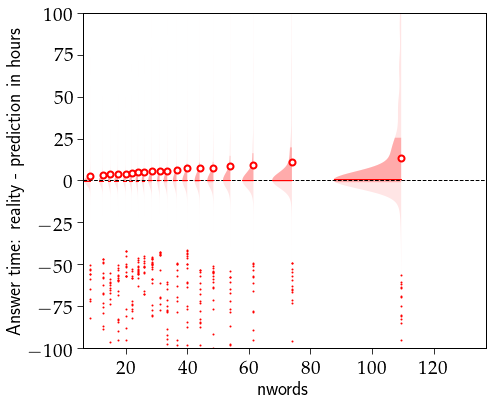

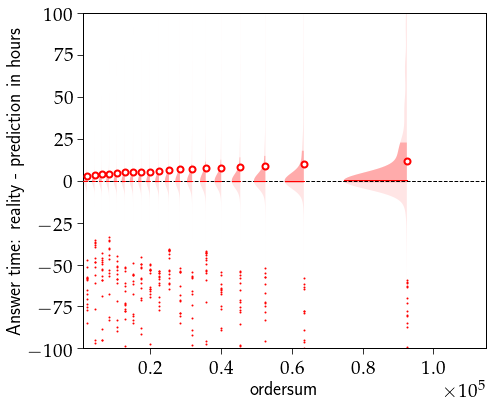

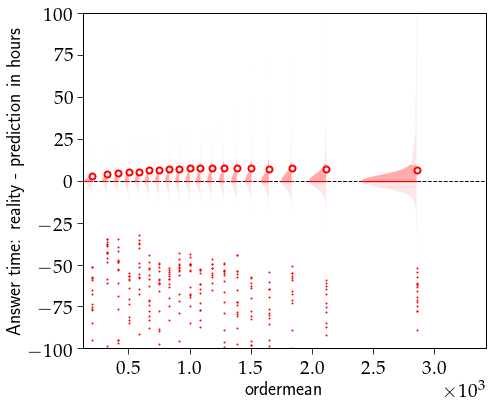

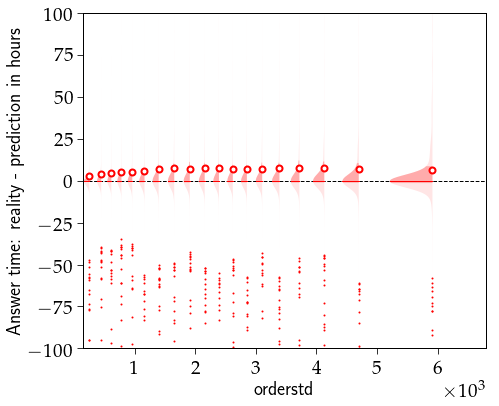

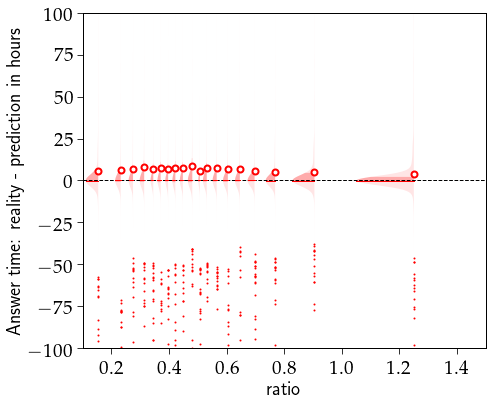

In [47]:
predtimes = np.e ** pred
cols = [col.replace("_norm", "") for col in qstrain.columns if "_norm" in col]
diff = qstest[label] - predtimes

for i, col in enumerate(cols):
    yquants = mquantiles(diff, prob=[0.05, 0.95])
    xquants = mquantiles(qstest[col], prob=np.linspace(0.01, 0.99, 20))
    plt.figure(i, figsize=(8, 6))
    plt.xlabel("%s" % col)
    plt.ylabel(r"Answer time: reality - prediction in hours")
    QuickSlicePlot(qstest[col], diff, qstest.dt_accanswer_hour, zbins=1, yrange=yquants, 
                   xbins=xquants, draw="amv", color="red", ms=6,
                   axes=plt.gca())
    plt.axhline(0, lw=1, ls="--", color="k")
    plt.ylim(-100, 100)
    plt.xlim(min(xquants), max(xquants))
    plt.savefig("./plots/residual_vs_%s.pdf" % col)

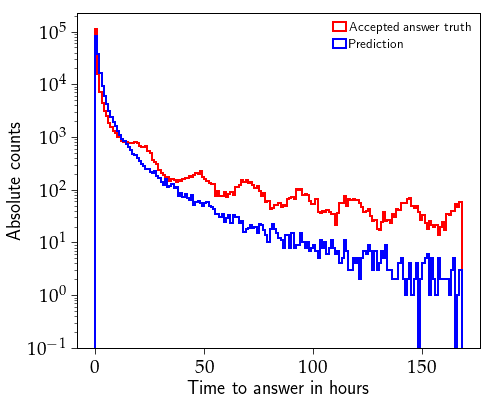

In [67]:
predtimes = np.e ** pred
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(predtimes, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_predictions.pdf")

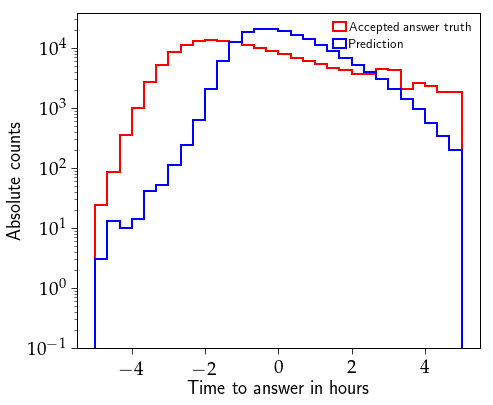

In [68]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour.apply(np.log), range=[-5, 5], bins=30,
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(np.log(predtimes), range=[-5, 5], bins=30,
         histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_log_predictions.pdf")

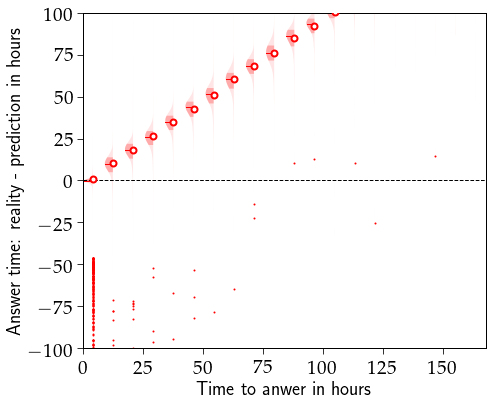

In [50]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to anwer in hours")
plt.ylabel(r"Answer time: reality - prediction in hours")
QuickSlicePlot(qstest.dt_answer_hour, diff, qstest.dt_accanswer_hour, zbins=1, yrange=[-50, 50], 
               xRange=[0, 7 * 24], xbins=20, draw="amv", color="red", ms=6,
               axes=plt.gca())
plt.axhline(0, lw=1, ls="--", color="k")
plt.ylim(-100, 100)
plt.xlim(0, 7 * 24)
plt.savefig("./plots/dtresidual_vs_dt.pdf")

## effect of the number of questions per time (more questions -> more answer delay?)

In [58]:
# number of 
date_edges = pd.date_range(qstrain.CreationDate.min(), qstrain.CreationDate.max(), freq="H")
# print date_edges
date_centers = date_edges[:-1] + (date_edges[1:] - date_edges[:-1]) / 2
date_centers = date_centers.to_pydatetime()
# print date_centers
allcounts = pd.cut(qstrain.CreationDate, bins=date_edges).value_counts().values[::-1]

In [62]:
allcounts.shape
date_edges.shape

(1716,)

In [ ]:
qstrain

In [88]:
print qstrain.shape
# doing it with groupby...more elegant
qrate = qstrain.groupby([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                         qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour]).size()

(200000, 46)


In [90]:
qstrainmulti = qstrain.set_index([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                                  qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour])
qstrainmulti["qrate"] = qrate
qstrain = qstrainmulti.reset_index(drop=True)
print qstrain.shape

(200000, 47)


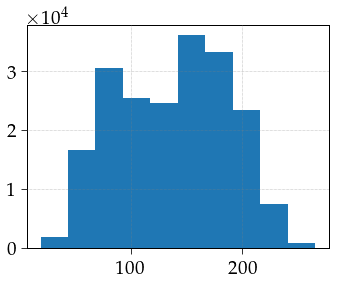

In [96]:
qstrain.qrate.hist()

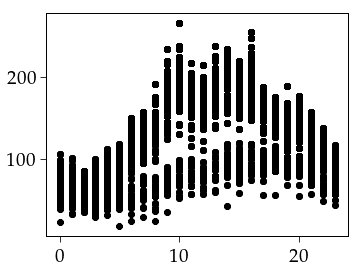

In [98]:
plt.plot(qstrain.CreationDate.dt.hour, qstrain.qrate, "k.")

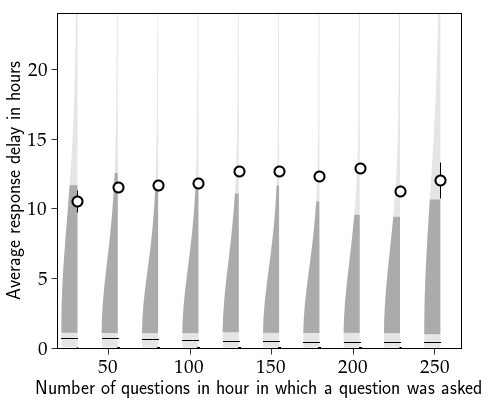

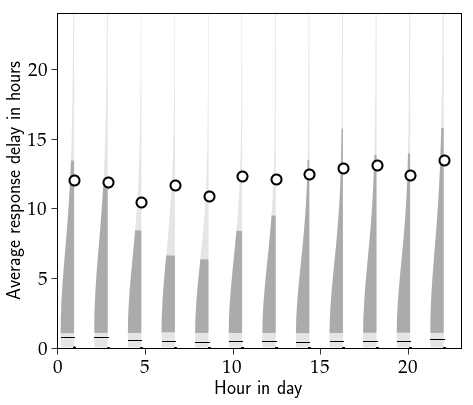

In [99]:
# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Number of questions in hour in which a question was asked")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.qrate, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=10,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()

# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Hour in day")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.CreationDate.dt.hour, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=12,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()